# Assignment: Feedbacks in the Radiative-Convective Model

This notebook is part of [The Climate Laboratory](https://brian-rose.github.io/ClimateLaboratoryBook) by [Brian E. J. Rose](http://www.atmos.albany.edu/facstaff/brose/index.html), University at Albany.

## Learning goals

Students completing this assignment will gain the following skills and concepts:

- Familiarity with setting up and running a single-column Radiative-Convective Model using climlab
- Familiarity with plotting and interpreting vertical air temperature data on meteorological Skew-T charts
- Use of climlab to perform controlled parameter-sensitivity experiments
- Understanding of the lapse rate feedback concept
- Calculation of radiative forcing and climate feedback parameters

## Question 1

Here you look at the effects of doubling CO$_2$ in the single-column Radiative-Convective model. 

*This exercise just repeats what we did in the lecture notes. You want to ensure that you can reproduce the same results before starting the next question, because you will need these results below.*

Following the lecture notes on climate sensitivity, do the following:

- set up a single-column radiative-convective model with specific humidity taken from the CESM control simulation
- Run this control model out to equilibrium
- Using a clone of the control model, calculate the stratosphere-adjusted radiative forcing $\Delta R$.
- Using another model clone, timestep the model out to equilibrium **with fixed specific humidity**
- Calculate the no-feedback Equilibrium Climate Sensitivity (ECS)
- Also calculate the no-feedback climate response parameter $\lambda_0$

Verify and show that you get the same results as we did in the lecture notes. 

*Copy Brian's code to set up a model*

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from metpy.plots import SkewT
import climlab

In [2]:
#  This code is used just to create the skew-T plot of global, annual mean air temperature
ncep_url = "http://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/ncep.reanalysis.derived/"
ncep_air = xr.open_dataset( ncep_url + "pressure/air.mon.1981-2010.ltm.nc", use_cftime=True)
#  Take global, annual average 
coslat = np.cos(np.deg2rad(ncep_air.lat))
weight = coslat / coslat.mean(dim='lat')
Tglobal = (ncep_air.air * weight).mean(dim=('lat','lon','time'))

#  Resuable function to plot the temperature data on a Skew-T chart
def make_skewT():
    fig = plt.figure(figsize=(9, 9))
    skew = SkewT(fig, rotation=30)
    #skew.plot(Tglobal.level, Tglobal, color='black', linestyle='-', linewidth=2, label='Observations')
    skew.ax.set_ylim(1050, 10)
    skew.ax.set_xlim(-90, 45)
    # Add the relevant special lines
    skew.plot_dry_adiabats(linewidth=0.5)
    skew.plot_moist_adiabats(linewidth=0.5)
    #skew.plot_mixing_lines()
    skew.ax.legend()
    skew.ax.set_xlabel('Temperature (degC)', fontsize=14)
    skew.ax.set_ylabel('Pressure (hPa)', fontsize=14)
    return skew

#  and a function to add extra profiles to this chart
def add_profile(skew, model, linestyle='-', color=None):
    line = skew.plot(model.lev, model.Tatm - climlab.constants.tempCtoK,
             label=model.name, linewidth=2)[0]
    skew.plot(1000, model.Ts - climlab.constants.tempCtoK, 'o', 
              markersize=8, color=line.get_color())
    skew.ax.legend()

# Get the water vapor data from CESM output
cesm_data_path = "http://thredds.atmos.albany.edu:8080/thredds/dodsC/CESMA/"
atm_control = xr.open_dataset(cesm_data_path + "cpl_1850_f19/concatenated/cpl_1850_f19.cam.h0.nc")
# Take global, annual average of the specific humidity
weight_factor = atm_control.gw / atm_control.gw.mean(dim='lat')
Qglobal = (atm_control.Q * weight_factor).mean(dim=('lat','lon','time'))

In [3]:
#  Make a model on same vertical domain as the GCM
mystate = climlab.column_state(lev=Qglobal.lev, water_depth=2.5)
#  Build the radiation model -- just like we already did
rad = climlab.radiation.RRTMG(name='Radiation',
                              state=mystate, 
                              specific_humidity=Qglobal.values,
                              timestep = climlab.constants.seconds_per_day,
                              albedo = 0.25,  # surface albedo, tuned to give reasonable ASR for reference cloud-free model
                             )
#  Now create the convection model
conv = climlab.convection.ConvectiveAdjustment(name='Convection',
                                               state=mystate,
                                               adj_lapse_rate=6.5,
                                               timestep=rad.timestep,
                                              )
#  Here is where we build the model by coupling together the two components
rcm = climlab.couple([rad, conv], name='Radiative-Convective Model')

Opened data from C:\Users\Owner\mini37\envs\climlab-courseware\lib\site-packages\climlab\radiation\data\ozone\apeozone_cam3_5_54.nc


In [4]:
print(rcm)

climlab Process of type <class 'climlab.process.time_dependent_process.TimeDependentProcess'>. 
State variables and domain shapes: 
  Ts: (1,) 
  Tatm: (26,) 
The subprocess tree: 
Radiative-Convective Model: <class 'climlab.process.time_dependent_process.TimeDependentProcess'>
   Radiation: <class 'climlab.radiation.rrtm.rrtmg.RRTMG'>
      SW: <class 'climlab.radiation.rrtm.rrtmg_sw.RRTMG_SW'>
      LW: <class 'climlab.radiation.rrtm.rrtmg_lw.RRTMG_LW'>
   Convection: <class 'climlab.convection.convadj.ConvectiveAdjustment'>



In [5]:
rcm.subprocess['Radiation'].absorber_vmr['CO2']

0.000348

*Run this model out to equilibrium*

In [6]:
rcm.integrate_years(5)

Integrating for 1826 steps, 1826.2110000000002 days, or 5 years.
Total elapsed time is 4.999422301147019 years.


In [7]:
rcm.ASR - rcm.OLR

Field([-3.36228823e-11])

*Using a clone of the control model, calculate the stratosphere-adjusted radiative forcing $\Delta R$.*

In [8]:
# Make an exact clone with same temperatures
rcm_2xCO2 = climlab.process_like(rcm)
rcm_2xCO2.name = 'Radiative-Convective Model (2xCO2 initial)'

In [9]:
#  Check to see that we indeed have the same CO2 amount
rcm_2xCO2.subprocess['Radiation'].absorber_vmr['CO2']

0.000348

In [10]:
#  Now double it!
rcm_2xCO2.subprocess['Radiation'].absorber_vmr['CO2'] *= 2

In [11]:
#  and verify
rcm_2xCO2.subprocess['Radiation'].absorber_vmr['CO2']

0.000696

In [12]:
rcm_2xCO2.compute_diagnostics()

In [13]:
rcm_2xCO2.ASR - rcm.ASR

Field([0.06274162])

In [14]:
rcm_2xCO2.OLR - rcm.OLR

Field([-2.11458541])

In [15]:
DeltaR_instant = (rcm_2xCO2.ASR - rcm_2xCO2.OLR) - (rcm.ASR - rcm.OLR)
DeltaR_instant

Field([2.17732704])

In [16]:
rcm_2xCO2_strat = climlab.process_like(rcm_2xCO2)
rcm_2xCO2_strat.name = 'Radiative-Convective Model (2xCO2 stratosphere-adjusted)'
for n in range(1000):
    rcm_2xCO2_strat.step_forward()
    # hold tropospheric and surface temperatures fixed
    rcm_2xCO2_strat.Tatm[13:] = rcm.Tatm[13:]
    rcm_2xCO2_strat.Ts[:] = rcm.Ts[:]

In [17]:
DeltaR = (rcm_2xCO2_strat.ASR - rcm_2xCO2_strat.OLR) - (rcm.ASR - rcm.OLR)
DeltaR

Field([4.28837377])

*My value for stratosphere-adjusted $\Delta R$ is 4.3 W/m$^2$, exactly the same as the lecture notes. (because I just copied them)*

*Using another model clone, timestep the model out to equilibrium with fixed specific humidity*

In [18]:
#  actual specific humidity
q = rcm.subprocess['Radiation'].specific_humidity
#  saturation specific humidity (a function of temperature and pressure)
qsat = climlab.utils.thermo.qsat(rcm.Tatm, rcm.lev)
#  Relative humidity
rh = q/qsat

In [19]:
rcm_2xCO2_h2o = climlab.process_like(rcm_2xCO2)
rcm_2xCO2_h2o.name = 'Radiative-Convective Model (2xCO2 equilibrium with H2O feedback)'

In [20]:
for n in range(2000):
    # At every timesteprcm_2xCO2_h2o = climlab.process_like(rcm_2xCO2)

    # we calculate the new saturation specific humidity for the new temperature
    #  and change the water vapor in the radiation model
    #  so that relative humidity is always the same
    qsat = climlab.utils.thermo.qsat(rcm_2xCO2_h2o.Tatm, rcm_2xCO2_h2o.lev)
    rcm_2xCO2_h2o.subprocess['Radiation'].specific_humidity[:] = rh * qsat
    rcm_2xCO2_h2o.step_forward()

In [21]:
# Check for energy balance
rcm_2xCO2_h2o.ASR - rcm_2xCO2_h2o.OLR

Field([-1.73179842e-07])

*Calculate the no-feedback Equilibrium Climate Sensitivity (ECS)*

In [22]:
rcm_2xCO2_eq = climlab.process_like(rcm_2xCO2_strat)
rcm_2xCO2_eq.name = 'Radiative-Convective Model (2xCO2 equilibrium)'
rcm_2xCO2_eq.integrate_years(5)

Integrating for 1826 steps, 1826.2110000000002 days, or 5 years.
Total elapsed time is 12.736753858124827 years.


In [23]:
ECS_nofeedback = rcm_2xCO2_eq.Ts - rcm.Ts
ECS_nofeedback

Field([1.29984831])

*again, my value is identical to the notes*

*Also calculate the no-feedback climate response parameter $\lambda_0$*

In [24]:
lambda0 = DeltaR / ECS_nofeedback
lambda0

Field([3.29913401])

*For fun/completeness, also calculate the ECS with water vapour feedback and compare with the lecture notes*

In [25]:
ECS = rcm_2xCO2_h2o.Ts - rcm.Ts
ECS

Field([2.98902357])

*My ECS is the same as Brian's at 3 W/m$^2$*

## Question 2: combined lapse rate and water vapor feedback in the RCM

### Instructions

A typical, expected feature of global warming is that the **upper troposphere warms more than the surface**. (Later we will see that this does occur in the CESM simulations).

This feature is **not represented in our radiative-convective model**, which is forced to a single prescribed lapse rate due to our convective adjustment.

Here you will suppose that other physical processes modify this lapse rate as the climate warms. 

**Repeat the RCM global warming calculation, but implement two different feedbacks:**

- a water vapor feedback using **fixed relative humidity**
- a **lapse rate feedback** using this formula:

$$ \Gamma = \Gamma_{ref} - (0.3 \text{ km}) \Delta T_s $$

where $\Gamma_{ref}$ is the critical lapse rate you used in your control model, probably 6.5 K / km, and $\Delta T_s$ is the **current value of the surface warming relative to the control** in units of K. 

So, for example if the model has warmed by 1 K at the surface, then our parameterization says that the critical lapse rate should be 6.5 - 0.3 = 6.2 K / km.

Follow the example in the lecture notes where we implemented the fixed relative humidity. In addition to adjusting the `specific_humidity` at each timestep, you should also change the attribute

```
adj_lapse_rate
```
of the convection process at each timestep.

For example, if you have a model called `mymodel` that contains a `ConvectiveAdjustment` process called `Convection`:
```
mymodel.subprocess['Convection'].adj_lapse_rate = newvalue
```
where `newvalue` is a number in K / km.

### Specific questions:

1. Make a nice skew-T plot that shows three temperature profiles:
    - RCM control
    - RCM, equilibrium after doubling CO$_2$ without feedback
    - RCM, equilibrium after doubling CO$_2$ with combined water vapor and lapse rate feedback
2. Based on your plot, where in the column do you find the greatest warming?
3. Calculate the ECS of the new version of the model with combined water vapor and lapse rate feedback
4. Is this sensitivity larger or smaller than the "no feedback" ECS? Is it larger or smaller than the ECS with water vapor feedback alone (which we calculated in the lecture notes)?
5. Calculate the combined feedback parameter for (water vapor plus lapse rate).
6. Compare this result to the IPCC figure with feedback results from comprehensive models in our lecture notes (labeled "WV+LR"). Do you find a similar number?
7. Would you describe the **lapse rate feedback** as positive or negative?



In [49]:
# use the same control rcm and non-feedback models as above, and create a new clone for combined feedback
rcm_2xCO2_wv_lr = climlab.process_like(rcm) # wv for water vapor, lr for lapse rate
rcm_2xCO2_wv_lr.name = 'RCM (2xCO2 initial, water vapor and lapse rate feedback)'
rcm_2xCO2_wv_lr.subprocess['Radiation'].absorber_vmr['CO2'] *= 2 # double the CO2

In [50]:
## copy the specific humididy feedback code
q = rcm_2xCO2_wv_lr.subprocess['Radiation'].specific_humidity
#  saturation specific humidity (a function of temperature and pressure)
qsat = climlab.utils.thermo.qsat(rcm_2xCO2_wv_lr.Tatm, rcm_2xCO2_wv_lr.lev)
#  Relative humidity
rh = q/qsat

In [51]:
## get reference lapse rate and surface temp from rcm control
gamma_ref = rcm.subprocess['Convection'].adj_lapse_rate
Ts_ref = rcm.Ts

print(gamma_ref)
print(Ts_ref)

6.5
[288.44785383]


In [52]:
for n in range(2000):
    # step the model forward
    rcm_2xCO2_wv_lr.step_forward()
    
    # do the water vapor feedback (copied from above):
    qsat = climlab.utils.thermo.qsat(rcm_2xCO2_wv_lr.Tatm, rcm_2xCO2_wv_lr.lev)
    rcm_2xCO2_wv_lr.subprocess['Radiation'].specific_humidity[:] = rh * qsat
    
    # do the lapse rate feedback:
    Ts = rcm_2xCO2_wv_lr.Ts
    rcm_2xCO2_wv_lr.subprocess['Convection'].adj_lapse_rate = gamma_ref - 0.3 * (Ts - Ts_ref) 

No handles with labels found to put in legend.


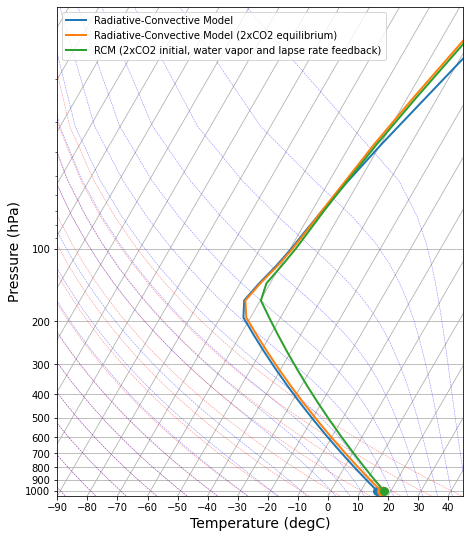

In [54]:
skew = make_skewT()
add_profile(skew, rcm)
add_profile(skew, rcm_2xCO2_eq)
add_profile(skew, rcm_2xCO2_wv_lr)

2. Based on your plot, where in the column do you find the greatest warming?

*By inpection, the greatest warming appears to be near the tropopause (which is also now at a higher altitude than before)*

3. Calculate the ECS of the new version of the model with combined water vapor and lapse rate feedback

In [62]:
ECS_combined = rcm_2xCO2_wv_lr.Ts - rcm.Ts
ECS_combined

Field([2.21590287])

4. Is this sensitivity larger or smaller than the "no feedback" ECS? Is it larger or smaller than the ECS with water vapor feedback alone (which we calculated in the lecture notes)?

*The combined-feedback ECS is larger than the model with no feedback, but smaller than with water vapor only*

5. Calculate the combined feedback parameter for (water vapor plus lapse rate).

*start by calculating the net feedback of the system $\lambda$, then subtract the value we calculated earlier for $\lambda_0$

$$
\lambda = \frac{\Delta R}{\Delta T}
$$

In [ ]:
lambda_net = 

____________

## Credits

This notebook is part of [The Climate Laboratory](https://brian-rose.github.io/ClimateLaboratoryBook), an open-source textbook developed and maintained by [Brian E. J. Rose](http://www.atmos.albany.edu/facstaff/brose/index.html), University at Albany.

It is licensed for free and open consumption under the
[Creative Commons Attribution 4.0 International (CC BY 4.0)](https://creativecommons.org/licenses/by/4.0/) license.

Development of these notes and the [climlab software](https://github.com/brian-rose/climlab) is partially supported by the National Science Foundation under award AGS-1455071 to Brian Rose. Any opinions, findings, conclusions or recommendations expressed here are mine and do not necessarily reflect the views of the National Science Foundation.
____________